# The evolution of trust and trustworthiness
## By Alex MARCELINO SANTEE, Jean-Nicolas GREGOIRE, Sacha TESTAERT

In [2]:
import numpy as np
import math
# import egttools as egt
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from abc import ABC, abstractmethod
from collections import Counter
import random

from multiprocessing import Pool

# from egttools.games import Matrix2PlayerGameHolder
# from scipy.integrate import odeint

### Parameters

##### Single game (Trust game, binary decision)
##### Strategies are a combination of A,B (T,R), (T,B), (N,R), (N,B)

##### Game matrix:
|     |  R                 |  B                |
|-----|------------------------|-------------------|
|  T  |  1 + (3r - 1)x, 3(1 - r)x  |  1 - x, 3x  |
|  N  |  1, 0              |  1, 0        |


### Trust Game Simulation Functions

In [3]:
def act2int(action: str):
    if action == "T" or action == "R":
        return 0
    else:
        return 1


def gen_trust_matrix(x=1, r=0.5):
    # Trust Game Matrix
    #   R B
    # T
    # N
    matrix = np.array([
        [[1-x+3*r*x, 3*x*(1-r)], [1-x, 3*x]],
        [[1, 0], [1, 0]],
    ])
    return matrix


def gen_strategies_matrix(x=1, r=0.5):
    # Strategies are (T,R), (T,B), (N,R), (N,B)
    # A\B  (TR) (TB) (NR) (NB)
    # (TR)
    # (TB)
    # (NR)
    # (NB)
    # Averaging the results for main diagonal (or we cant use egttools)
    base = gen_trust_matrix(x, r)
    matrix = np.empty((4, 4))
    # using bit 1 is T/N, bit 0 is R/B
    for i in range(4):
        for j in range(4):
            if i < j:  # over main diagonal is A reward
                matrix[i, j] = base[i // 2, j % 2, 0]
            elif i > j:  # below main diagonal is B reward
                matrix[i, j] = base[i // 2, j % 2, 1]
            else:  # i==j
                matrix[i, j] = np.sum(base[i // 2, j % 2])/2
    return matrix

# Multiple network types - pair are generated from connected nodes
# well-mixed, lattice (triangle, square, hexagon), random and scale-free
# heterogeneous networks can consider different degree (normalized) or not
# unnormalized scale-free network is the only to evolve trust


class AgentNetwork(ABC):
    @abstractmethod
    def sample_neighbors(self, agent, n=4, replacement=True):
        pass

    def get_strategy(self, agent):
        return self.strategies[agent]

    def set_strategy(self, agent, strategy):
        if strategy in strategy_labels:
            self.strategies[agent] = strategy
            return
        else:
            raise ValueError("Setting invalid strategy: " + str(strategy))

    def get_ratios(self):
        count = Counter(self.strategies)
        ratios = np.empty(nb_strategies)
        for i, strategy in enumerate(strategy_labels):
            ratios[i] = count[strategy]
        return ratios/self.size

    def get_size(self):
        return self.size
    
    def __str__(self):
        return str(self.strategies)

### Well mixed network

In [4]:
class WellMixed(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.strategies = random.choices(strategy_labels, k=size)
        self.cs = 1024  # cache size
        self.sample_cache = []  # improves sampling performance
        for _ in range(self.size):
            self.sample_cache.append([self.cs, np.empty((self.cs, 4))])


    def sample_neighbors(self, agent, n=4, replacement=True):
        if replacement:
            if self.sample_cache[agent][0] >= self.cs:
                neighbors = [x for x in range(self.size) if x != agent]
                self.sample_cache[agent][1] = np.random.choice(neighbors,
                                                               (self.cs, n))
                self.sample_cache[agent][0] = 0
            agents = self.sample_cache[agent][1][self.sample_cache[agent][0]]
            self.sample_cache[agent][0] += 1
        else:
            neighbors = [x for x in range(self.size) if x != agent]
            agents = random.sample(neighbors, n)
        return agents

### Square lattice network

In [5]:
class SquareLattice(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.rows = math.ceil(self.size**(1/2))
        self.cols = math.ceil(self.size**(1/2))
        self.network = self._create_square_lattice(self.rows, self.cols)
        self.strategies = random.choices(strategy_labels, k=self.size)

    def _create_square_lattice(self, rows, cols):
        G = nx.grid_2d_graph(rows, cols, periodic=True) #must remain to True, otherwise the network is padded
        mapping = {node: idx for idx, node in enumerate(G.nodes)}
        # Relabel nodes in the graph using the mapping 
        # (G is first created with tuples representing nodes id and coordinates 
        # but since we want to sample over them, it's easier with one dimensional identificator)
        G = nx.relabel_nodes(G, mapping)
        return G    
    
    def sample_neighbors(self, agent, n=4, replacement=True):
        neighbors = list(self.network.neighbors(agent))
        if replacement or len(neighbors) < n:
            agents = np.random.choice(neighbors, n)
        else:
            agents = random.sample(neighbors, n)
        return agents


### Triangle lattice network

In [6]:
class TriangleLattice(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.rows = math.ceil(self.size**(1/2)*2)
        self.cols = math.ceil(self.size**(1/2))
        self.network = self._create_triangular_lattice(self.rows, self.cols)
        self.strategies = random.choices(strategy_labels, k=self.size)

    def _create_triangular_lattice(self, rows, cols):
        G = nx.triangular_lattice_graph(rows, cols, periodic=True) 
        mapping = {node: idx for idx, node in enumerate(G.nodes)}
        G = nx.relabel_nodes(G, mapping)
        return G
    
    def sample_neighbors(self, agent, n=4, replacement=True):
        neighbors = list(self.network.neighbors(agent))
        if replacement or len(neighbors) < n:
            agents = np.random.choice(neighbors, n)
        else:
            agents = random.sample(neighbors, n)
        return agents

### Hexagonal lattice network

In [7]:
class HexagonLattice(AgentNetwork):
    def __init__(self, size):
        self.size = size
        self.rows = math.ceil(self.size**(1/2)/2)
        self.cols = math.ceil(self.size**(1/2))
        self.network = self._create_hexagonal_lattice(self.rows, self.cols)
        self.strategies = random.choices(strategy_labels, k=self.size)

    def _create_hexagonal_lattice(self, rows, cols):
        G = nx.hexagonal_lattice_graph(rows, cols, periodic=True)
        mapping = {node: idx for idx, node in enumerate(G.nodes)}
        G = nx.relabel_nodes(G, mapping)
        return G
    
    def sample_neighbors(self, agent, n=4, replacement=True):
        neighbors = list(self.network.neighbors(agent))
        if replacement or len(neighbors) < n:
            agents = np.random.choice(neighbors, n)
        else:
            agents = random.sample(neighbors, n)
        return agents
    

### Simulation

###### Copy of other players actions with probability from eq. 2.1
###### 1 / ( 1 + e^(tot_payoff_p2-tot_payoff_p1)/K ) for K=0.1
###### number of MC steps equals to population size N=500
###### Initializes each player randomly consists in chosing two players P1, P2 and playing the game w/ 4 neighbors

In [8]:

def simulation_step(
        network: AgentNetwork,
        payoff_matrix: np.ndarray,
        ):
    N_PLAYERS = 2
    N_GAMES = 4
    K = 0.1

    # sample 2 players according to the lattices requirements if it is a Lattice instance 
    # else according to the WellMixed population criteria
    if not isinstance(network, WellMixed):
        players = random.sample(range(network.get_size()), 1) # this is for well mixed populations
        players.extend(network.sample_neighbors(players[0],1,replacement=False))

    else:
        players = random.sample(range(network.get_size()), N_PLAYERS) # this is for well mixed populations

    payoffs = N_PLAYERS*[0]
    for play_idx, player in enumerate(players):
        # plays 4 games for each player
        adversaries = network.sample_neighbors(player, n=N_GAMES)
        for adversary in adversaries:

            # decide roles
            role = random.randint(0, 1)  # 0 player sends, 1 player receive
            # gets actions
            if role == 0:
                act0 = network.get_strategy(player)[1]
                act1 = network.get_strategy(adversary)[3]
            else:
                act0 = network.get_strategy(adversary)[1]
                act1 = network.get_strategy(player)[3]
            # calculates payoff for the game
            payoff = payoff_matrix[act2int(act0), act2int(act1), role]

            payoffs[play_idx] += payoff

        # p2 copies p1 with chance w
        w = 1 / (1 + np.exp(payoffs[1]-payoffs[0])/K)
        if random.random() < w:
            network.set_strategy(players[1],
                                 network.get_strategy(players[0]))

    return network


def simulation_single_run(payoff_matrix: np.ndarray, population_type: str="TriangleLattice", pop_size=484):
    results = np.empty((nb_time_steps, nb_strategies))

    if population_type == "SquareLattice":
        network = SquareLattice(pop_size)
        #print(network.network.number_of_nodes())

    elif population_type == "TriangleLattice":
        network = TriangleLattice(pop_size)
        #print(network.network.number_of_nodes())

    elif population_type == "HexagonLattice":
        network = HexagonLattice(pop_size)
        #print(network.network.number_of_nodes())
    elif population_type == "WellMixed":
        network = WellMixed(pop_size)

    for timestep in range(nb_time_steps):
        for _ in range(pop_size):  # Each MC step is the size of population
            network = simulation_step(network, payoff_matrix)
        results[timestep] = network.get_ratios()
    return results


def run_simulation(payoff_matrix: np.ndarray):
    results = np.empty((nb_runs, nb_time_steps, nb_strategies))
    with Pool(processes=n_threads) as p:
        it = p.imap_unordered(simulation_single_run, nb_runs*[payoff_matrix])
        for run, result in enumerate(it):
            results[run] = result
    return results


### Plotting

#### 1- Proportion of population sweeping through x and r
#### 2- Evolution Through time given x and r

---

###### Research question - what if keep memory of neighbor, can we train for (x,r)? What are ultimatum game and dictator game?
###### To trust or not to trust proposes a better N-player generalization with code and found incentives to trustees and non-linear reward create rich evolution hierarchical trust fixes proportion of trusters and trustees and introduces punishing truster, getting stability of trustworthy and punishers.

###### N-player trust game proposes variation with governors and citizens which players can select what to be (doesn't look interesting) converge to no trust unless population is full of trustworthy. To trust or not to trust cites it directly, but with strong criticism

In [9]:


def plot_heatmaps(avg_results):
    fig, axs = plt.subplots(figsize=(10, 5), ncols=2, nrows=2)

    im = axs[0, 0].imshow(avg_results[:, :, 0], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[0, 1].imshow(avg_results[:, :, 1], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[1, 0].imshow(avg_results[:, :, 2], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[1, 1].imshow(avg_results[:, :, 3], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)

    axs[0, 0].text(0.8, 0.8, "(T,R)", backgroundcolor="white")
    axs[0, 1].text(0.8, 0.8, "(T,B)", backgroundcolor="white")
    axs[1, 0].text(0.8, 0.8, "(N,R)", backgroundcolor="white")
    axs[1, 1].text(0.8, 0.8, "(N,B)", backgroundcolor="white")

    axs[0, 0].set_xticks([])
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    axs[1, 1].set_yticks([])

    axs[0, 0].set_ylabel("$r$", fontsize=14)
    axs[1, 0].set_ylabel("$r$", fontsize=14)
    axs[1, 0].set_xlabel("$x$", fontsize=14)
    axs[1, 1].set_xlabel("$x$", fontsize=14)

    fig.colorbar(im, ax=axs[:, :])
    plt.show()


[[[0.92 1.68]
  [0.2  2.4 ]]

 [[1.   0.  ]
  [1.   0.  ]]]


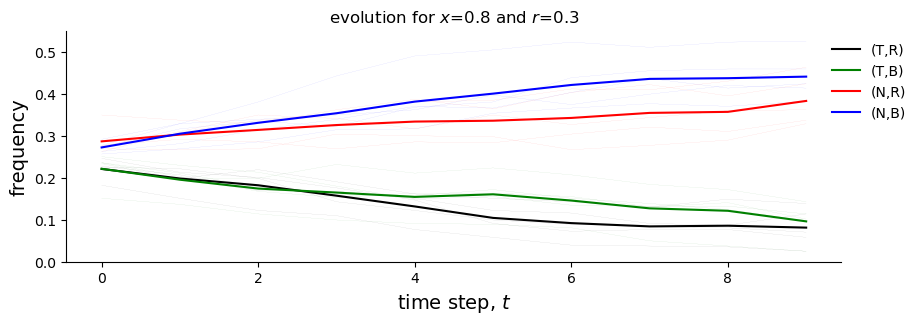

x = 0.0
x = 0.05263157894736842
x = 0.10526315789473684
x = 0.15789473684210525
x = 0.21052631578947367
x = 0.2631578947368421
x = 0.3157894736842105
x = 0.3684210526315789
x = 0.42105263157894735
x = 0.47368421052631576
x = 0.5263157894736842
x = 0.5789473684210527
x = 0.631578947368421
x = 0.6842105263157894
x = 0.7368421052631579
x = 0.7894736842105263
x = 0.8421052631578947
x = 0.894736842105263
x = 0.9473684210526315
x = 1.0


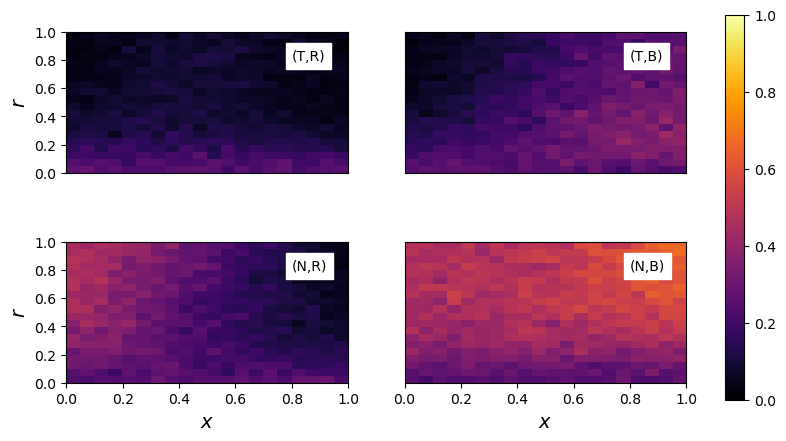

In [10]:
colors = ["black", "green", "red", "blue"]
strategy_labels = ["(T,R)", "(T,B)", "(N,R)", "(N,B)"]

nb_strategies = 4
nb_runs = 5 #128
nb_time_steps = 10
n_threads = 16
x, r = (0.8, 0.3)
game_matrix = gen_strategies_matrix(x, r)
game_matrix = gen_trust_matrix(x, r)
print(game_matrix)
# game = Matrix2PlayerGameHolder(4, game_matrix)

t = np.arange(0, nb_time_steps)
results = run_simulation(game_matrix)
results = np.asarray(results)

# Plot for population evolution

fig, ax = plt.subplots(figsize=(10, 3))

for run in results:
    for i in range(nb_strategies):
        ax.plot(t, run[:, i],
                linewidth=.05, alpha=0.6, color=colors[i])

for i in range(nb_strategies):
    ax.plot(t, np.mean(results[:, :, i], axis=0), linewidth=1.5,
            alpha=1, color=colors[i], label=strategy_labels[i])

ax.set_title(f"evolution for $x$={x} and $r$={r}")
ax.legend(frameon=False, bbox_to_anchor=(1.1, 1, 0, 0), loc='upper right')
ax.set_ylabel("frequency", fontsize=14)
ax.set_xlabel("time step, $t$", fontsize=14)
# ax.set_ylim(-0.2, 1.2)
sns.despine()
plt.show()

# Sweep plot

xs = np.linspace(0, 1, 20)
rs = np.linspace(0, 1, 20)
t = np.arange(0, 10, 10/nb_time_steps)
final_proportions = np.empty((xs.shape[0], rs.shape[0], nb_strategies))
for i, x in enumerate(xs):
    for j, r in enumerate(rs):
        payoff = gen_trust_matrix(x, r)
        result = np.array(run_simulation(payoff))
        final_proportions[i, j] = np.sum(result[:, -1, :], axis=0)/nb_runs
    print("x =", x)
plot_heatmaps(final_proportions)

Now that we studied the evolution of densities around their network structure, we try and analyze the evolution of strategies according to the variation of the noise in the replicator dynamycs.

With the values K = 1, K = 10, K = 100